# CS985/6 Spotify Regression Problem 2024
## CS986FoMLDAGroup2
- Aravinthkumar Pattaiyan 202367339
- Liyi Tan 202383002
- Blaise Marvin Rusoke 202354498 
- Shrishti Sridhar Manja 202362138
- Hrutuja Mangesh Patkar 202389142

# 1.0 Introduction

For our group project, we're focusing on predicting song popularity by analyzing various attributes like ID, title, artist, top genre, year, BPM, energy, danceability, loudness, live performance, valence, duration, acousticness, and speechiness. Through thorough exploratory data analysis (EDA), feature selection, and data preprocessing, we aim to understand how these attributes influence the popularity of a song. Our goal is to build a Machine Learning Regressor Model that accurately predicts the popularity score based on these features.

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 2.0 Data Overview
Each instance represents a unique track along with its independant feature variables.

Id - an arbitrary unique track identifier
title - track title
artist - singer or band
top genre - genre of the track
year - year of release (or re-release)
bpm - beats per minute (tempo)
nrgy - energy: the higher the value the more energetic
dnce - danceability: the higher the value, the easier it is to dance to this song
dB - loudness (dB): the higher the value, the louder the song
live - liveness: the higher the value, the more likely the song is a live recording
val - valence: the higher the value, the more positive mood for the song
dur - duration: the length of the song
acous - acousticness: the higher the value the more acoustic the song is
spch - speechiness: the higher the value the more spoken word the song contains
pop - popularity: the higher the value the more popular the song is (and the target variable for this problem)

### 2.1  Read data into memory:

In [2]:
training_df = pd.read_csv('data/CS98XRegressionTrain.csv')
test_df = pd.read_csv('data/CS98XRegressionTest.csv')
training_df.shape

(453, 15)

### 2.2 Visually investigating the structure of our data through a few columns:

In [3]:
training_df.head()

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77
3,4,Woman in Love,Barbra Streisand,adult standards,1980,170,28,47,-16,13,33,232,25,3,67
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,glam rock,1973,121,47,56,-8,15,40,193,45,3,63


# 3.0 Exploratory Data Analysis

### 3.1 Checking the dataset for null values:

In [4]:
training_df.isna().any()

Id           False
title        False
artist       False
top genre     True
year         False
bpm          False
nrgy         False
dnce         False
dB           False
live         False
val          False
dur          False
acous        False
spch         False
pop          False
dtype: bool

### 3.2 Dropping Null Values

Null values were found in the top genre column. Since we do not have any other information to infer these missing values, we decided to drop them.

In [5]:
training_df=training_df.dropna()

### 3.3 Investigating relationship between target variables and features

Before training any machine learning models, we visually investigated the relationship between the features and the target popularity variable in order to generate assumptions about the data which would then guide our model selection process. 

In [6]:
numerical_columns = list(training_df.dtypes[training_df.dtypes != 'object'].index.values)

The scatter plots below illustrate the relationship between the target popularity variable and the numeric features. An observation of these plots illustrates the predominantly non-linear relationship between the features and target variable. These observed insights inspired our use of models such as DecisionTreeRegressors, RandomForestEnsembles and XGBoost which are capable of capturing such non-linear relationships

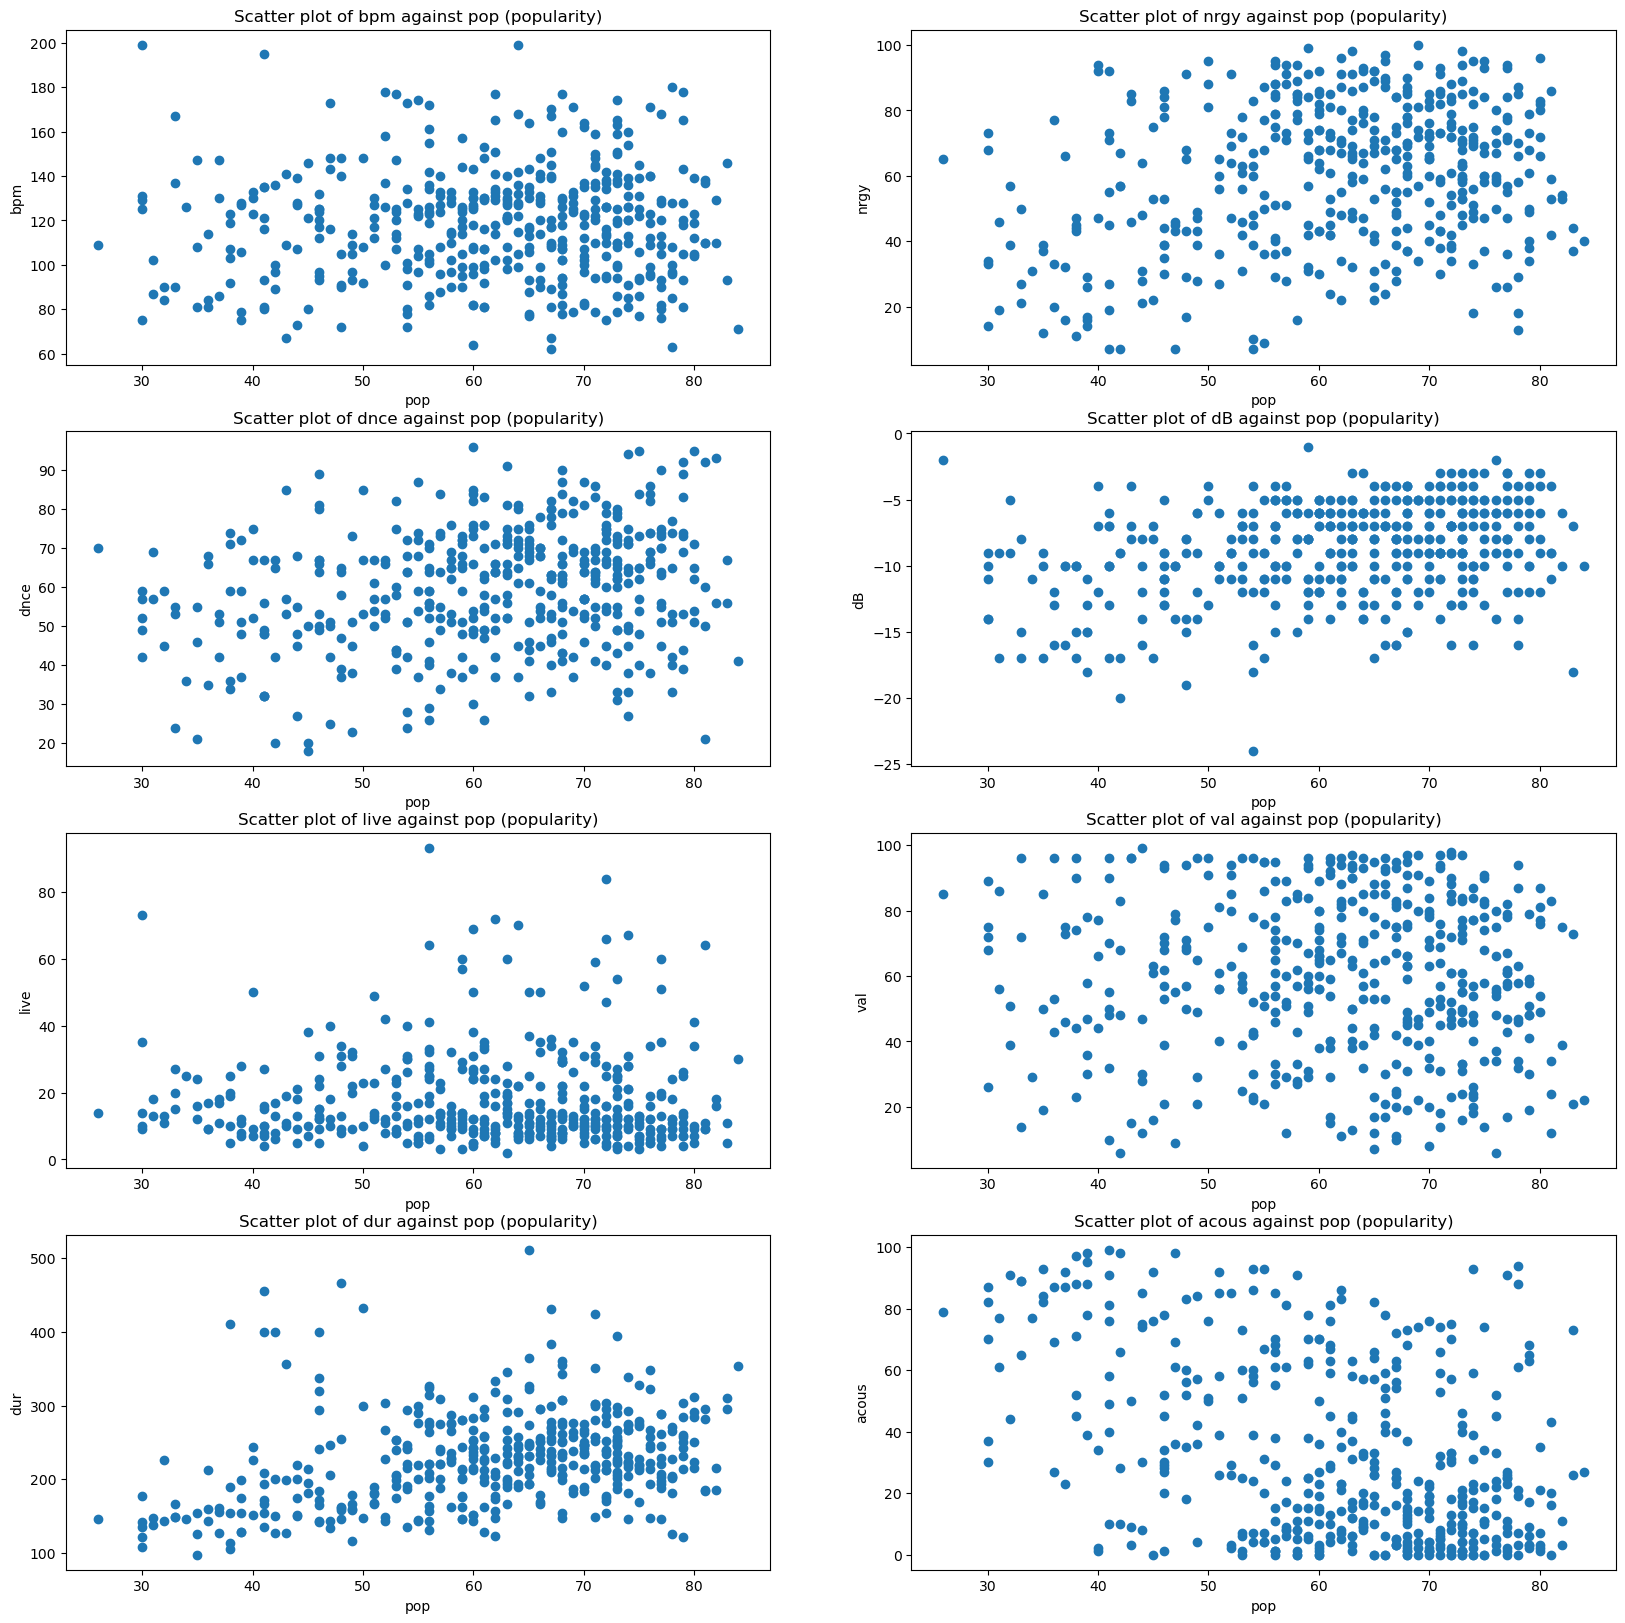

In [7]:
cols = ['bpm','nrgy','dnce','dB','live','val','dur','acous']
fig,ax = plt.subplots(4,2,figsize=(20,20))
index = 0
for i in range(4):
    for j in range(2):
        ax[i,j].scatter(x=training_df['pop'],y=training_df[cols[index]])
        ax[i, j].set_title(f'Scatter plot of {cols[index]} against pop (popularity)')
        ax[i, j].set_xlabel('pop') 
        ax[i, j].set_ylabel(cols[index])
        index+=1

### 3.4 Investigating data distribution of features

 We also investigated the distribution of the numerical attributes in the dataset and a significant deviation from the normal distribution was observed for most columns such as spch, live, acous and dur, which were significantly positively skewed. The insights from these plots below guided our data preprocessing steps.

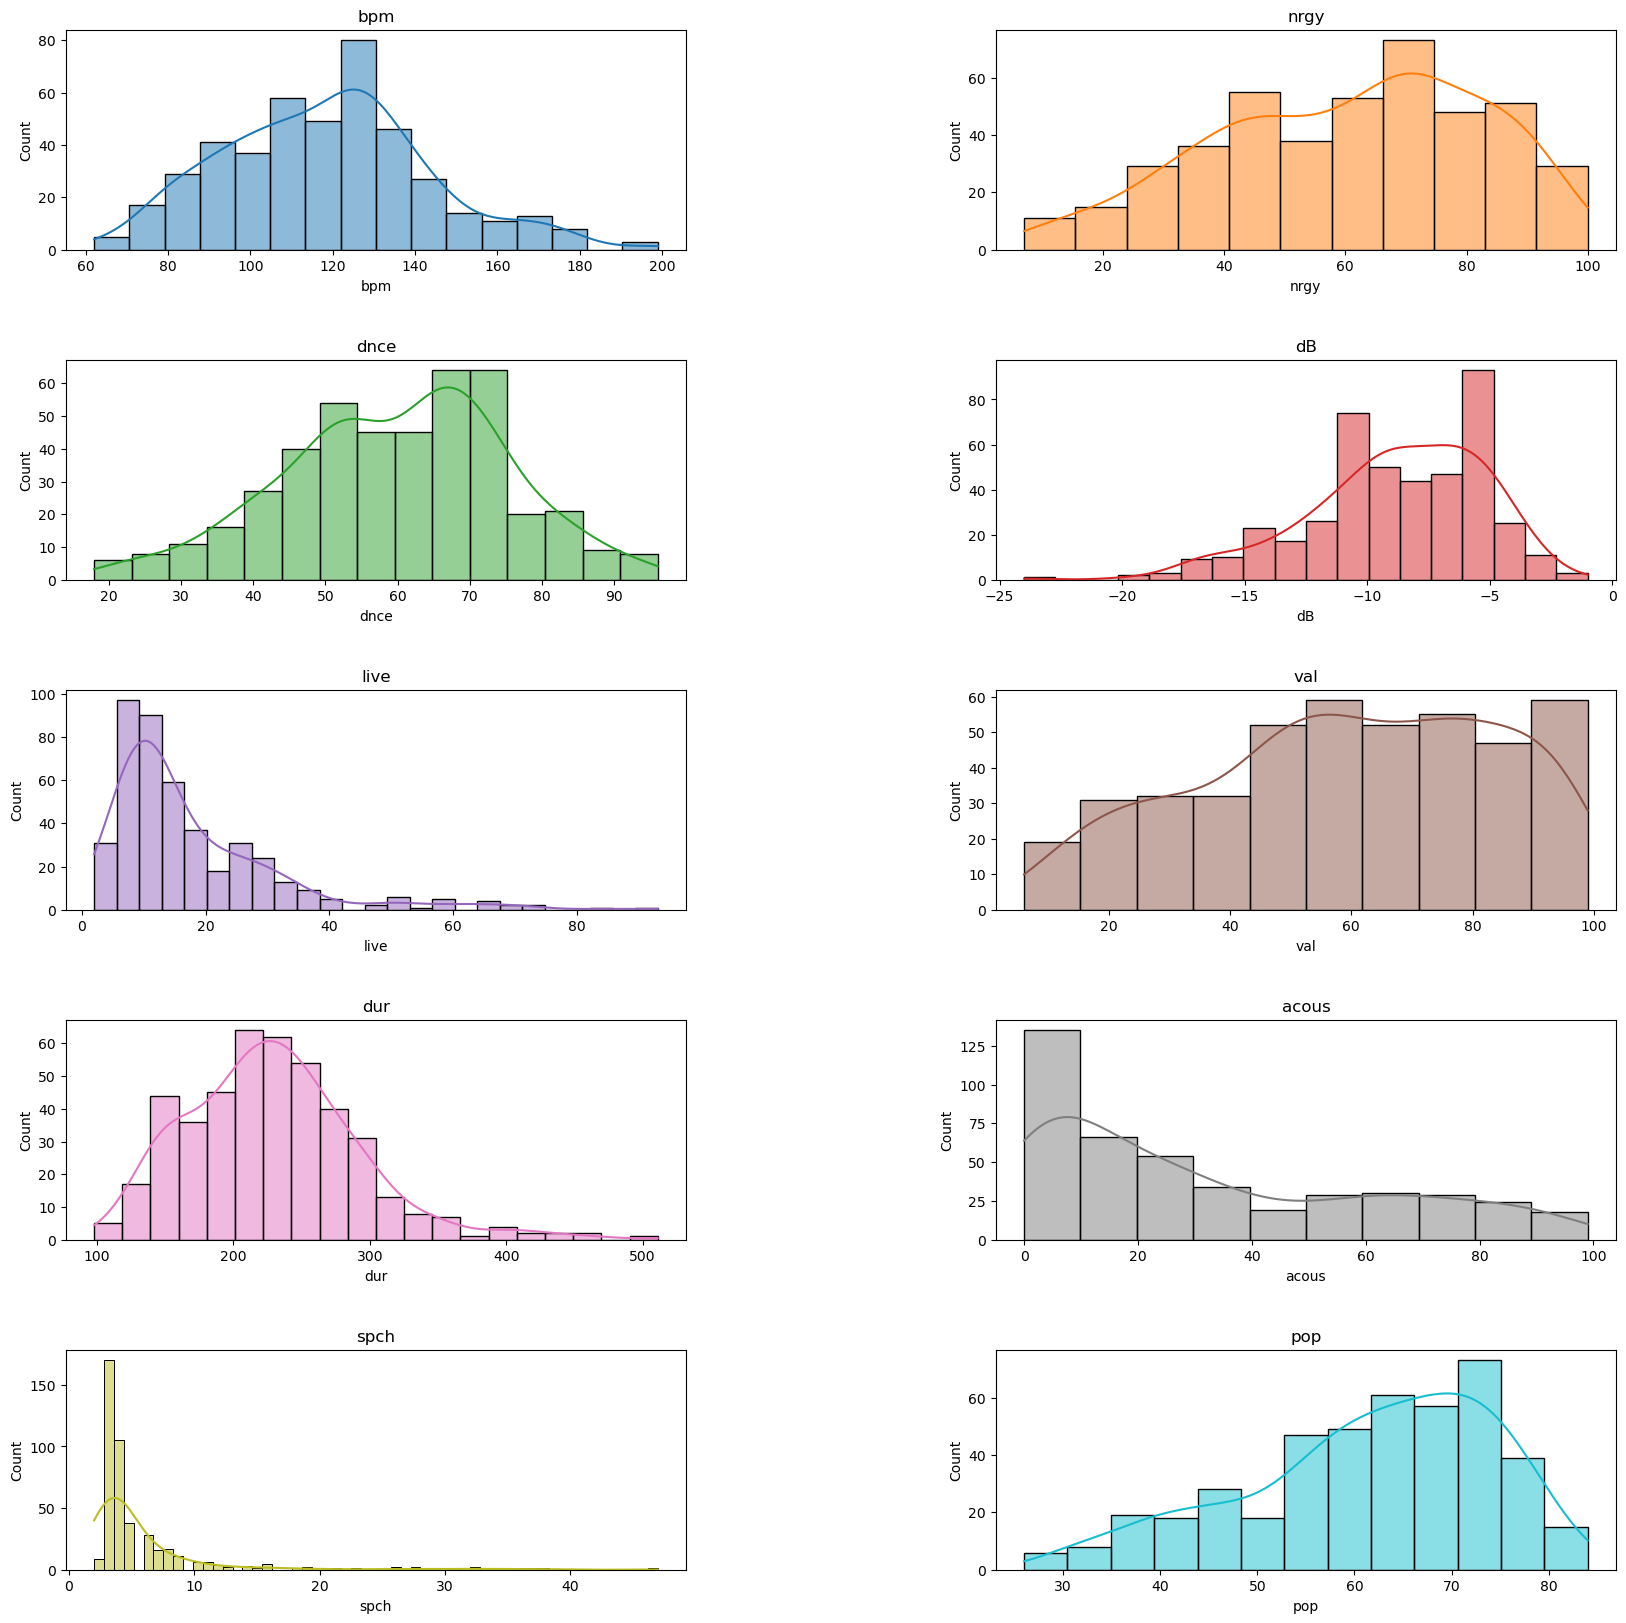

In [8]:
cols = ['bpm','nrgy','dnce','dB','live','val','dur','acous','spch','pop']
colors = plt.cm.tab10.colors[:10]
fig,ax = plt.subplots(5,2,figsize=(20,20))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
index = 0
for i in range(5):
    for j in range(2):
        sns.histplot(x=training_df[cols[index]], ax=ax[i,j], color=colors[index], kde=True).set(title=cols[index])
        index+=1

# 4.0 Data Preprocessing

### 4.1 Spliting data into features and labels.

In [9]:
X = training_df.drop(columns=['pop'])
Y = training_df['pop'].values

### 4.2 Removing insignificant variables

Learning from our exploratory data analysis, we decided to remove the below three attributes least important to the popularity of the song.

In [10]:
del X['Id']
del X['title']
del X['spch']

### 4.3 Splitting into training and validation

We then split our dataset into a training and validation set, taking a validation size of 10% to ensure we have enough training data.

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.10, random_state=42)

### 4.4 Data Preprocessing Pipeline
Because our training set contains categorical variables, we built a preprocessing pipeline to encode these values using a one hot encoder. Furthermore, we also applied the "yeo-johnson" power transformation to the numerical columns in our dataset. This transformation ensured our numerical attributes followed the normal distribution and also eliminated the observed skewness and general deviation from a normal distribution. The transformations also resulted in a significant performance boost.

In [12]:
# numerical columns pipeline
num_pipeline = make_pipeline(PowerTransformer(method="yeo-johnson"))

# categorical columns pipeline
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False,handle_unknown='ignore'))

# target columns transformer
target_transformer = PowerTransformer(method='yeo-johnson')

In [13]:
# features preprocessing transformer
preprocessing = ColumnTransformer([
    ('num',num_pipeline,['bpm','nrgy','dnce','dB','live','val','dur','acous']),
    ('cat',cat_pipeline,['top genre','artist','year'])
])

### 4.5 Transforming the data

In [14]:
#fitting the transformation on the features from training dataset
x_train = preprocessing.fit_transform(x_train)
#fitting the transformation on the features from validation dataset
x_val = preprocessing.transform(x_val)

In [15]:
#fitting the transformation on the predictor variable from training dataset
y_train = target_transformer.fit_transform(y_train.reshape(-1,1))
y_train=y_train.reshape(y_train.shape[0],)

In [16]:
#fitting the transformation on the predictor variable from validation dataset
y_val = target_transformer.transform(y_val.reshape(-1,1))
y_val = y_val.reshape(y_val.shape[0],)

# 5.0 Model Selection
### 5.1 Decision Tree Regressor-
Decision trees are often used as baseline models due to their simplicity and ability to capture non-linear relationships in the data. In this case, with observed non-linear relationships in the dataset, a decision tree regressor was chosen as the baseline model.

In [17]:
params = {
    'max_depth':[2,4,6,8,10,12],
    'min_samples_leaf':[1,2,4,6,8,10,12]
}

In [18]:
gridsearch_dr = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=1),
    param_grid=params,
    scoring='neg_root_mean_squared_error',
    verbose=5,
    cv=3,
    n_jobs=8
)

In [19]:
gridsearch_dr.fit(x_train,y_train);

Fitting 3 folds for each of 42 candidates, totalling 126 fits


In [20]:
gridsearch_dr.best_params_

{'max_depth': 2, 'min_samples_leaf': 8}

In [21]:
dr = DecisionTreeRegressor(max_depth=2,min_samples_leaf=8).fit(x_train,y_train)

#### Using Root Mean Square Error[RMSE] for Error Validation on the VALIDATION set for the Decision Tree Regressor Model.

In [22]:
pred_dr = dr.predict(x_val)
transformed_pred_dr = target_transformer.inverse_transform(pred_dr.reshape(-1,1))
transformed_y_val = target_transformer.inverse_transform(y_val.reshape(-1,1))
np.sqrt(mean_squared_error(transformed_y_val,transformed_pred_dr))

8.756855547158997

#### Using Root Mean Square Error[RMSE] for Error Validation on the TRAINING set for the Decision Tree Regressor Model.

In [23]:
pred_dr = dr.predict(x_train)
transformed_pred_dr = target_transformer.inverse_transform(pred_dr.reshape(-1,1))
transformed_y_train = target_transformer.inverse_transform(y_train.reshape(-1,1))
np.sqrt(mean_squared_error(transformed_y_train,transformed_pred_dr))

10.662075081998946

### 5.2 Random Forest Regressor
We then employed a random forest regressor, to improved the observed performance of the decision tree regressor and finetuned it using gridsearch.  Random forests are an extension of decision trees and are known for their robustness and ability to handle complex datasets with high dimensionality.

#####  Model Finetuning:

Grid search is a method for systematically exploring hyperparameter combinations to find the optimal settings for a machine learning model. Gridsearch was used for  evaluating each combination using cross-validation,  to identify the hyperparameters that result in the best performance on a validation set. This process is crucial for improving the model's accuracy and generalization ability.

In [24]:
params = {
    'max_depth':[2,4,6,8],
    'min_samples_leaf':[2,4,6,8],
    'n_estimators':[100,200,400,600]
}

In [25]:
gridsearch_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=1),
    param_grid=params,
    scoring='neg_root_mean_squared_error',
    verbose=5,
    cv=3,
    n_jobs=8
)
# gridsearch_rf.fit(x_train,y_train)
# gridsearch_rf.best_params_

The model was trained on the optimal parameters discovered through gridsearch, which is now commented out because of the time it takes to run.

In [26]:
rf2 = RandomForestRegressor(max_depth=4,min_samples_leaf=8,n_estimators=100).fit(x_train,y_train);

#### Using Root Mean Square Error[RMSE] for Error Validation on the VALIDATION set for the Random Forest Regressor Model.

In [27]:
pred_rf = rf2.predict(x_val)
transformed_y_val = target_transformer.inverse_transform(y_val.reshape(-1,1))
transformed_pred_rf = target_transformer.inverse_transform(pred_rf.reshape(-1,1))
np.sqrt(mean_squared_error(transformed_y_val,transformed_pred_rf))

8.323494701942064

#### Using Root Mean Square Error[RMSE] for Error Validation on the TRAINING set for the Random Forest Regressor Model.

In [28]:
train_pred_rf = rf2.predict(x_train)
train_pred_rf = target_transformer.inverse_transform(train_pred_rf.reshape(-1,1))
np.sqrt(mean_squared_error(transformed_y_train,train_pred_rf))

9.478738262215616

Random Forest Regressor might not fully capture the intricate relationships present in the data. XGBoost, with its boosted ensemble approach, has a higher capacity to learn complex patterns by sequentially improving upon the weaknesses of preceding models.


### 5.3 XGBoost Method
XGBoost is a powerful ensemble learning technique that combines the strengths of gradient boosting and regularization techniques. It is highly flexible, scalable, and capable of capturing complex patterns in the data. We  tried the boosting ensemble technique, for predicting popularity of a song and finetuned it using gridsearch.

In [29]:
reg = xgb.XGBRegressor(objective='reg:squarederror',seed=42,eval_metric='rmse',early_stopping_rounds=50,random_state=1)


##### Model finetuning using Gridsearch:

In [30]:
parameters2 = {
    'learning_rate':[0.001,0.01,0.05,0.1],
    'max_depth': [1,2,4,6,8,10], # tree depth
    'reg_lambda':[1.0,10.0,15.0,20.0], # control model regularization
    'subsample': [0.4, 0.9,1.0], #fraction of training instances to sample
    'colsample_bytree':[0.4, 0.9,1.0] # fraction of features to sample
}

In [31]:
gridsearch = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror',seed=42,eval_metric='rmse'),
    param_grid=parameters2,
    scoring='neg_root_mean_squared_error',
    verbose=5,
    cv=3,
    n_jobs=8
)
# gridsearch.fit(x_train,y_train);
# gridsearch.best_params_

The model was trained on the optimal parameters discovered through gridsearch, which is now commented out because of the time it takes to run.

#####  Fitting an XGBoost Model on the obtained parameters:

In [32]:
reg2 = xgb.XGBRegressor(objective='reg:squarederror',seed=42,eval_metric='rmse',early_stopping_rounds=50,random_state=1,
                      colsample_bytree=0.9,learning_rate=0.05,max_depth=6,reg_lambda=20.0,subsample=0.4)

In [33]:
reg2.fit(x_train,y_train,eval_set=[(x_val,y_val)],verbose=False);

#### Using Root Mean Square Error[RMSE] for Error Validation on the VALIDATION set for the XGBoost Regressor Model.

In [34]:
pred_rf2 = reg2.predict(x_val)
transformed_pred_rf2 = target_transformer.inverse_transform(pred_rf2.reshape(-1,1))
np.sqrt(mean_squared_error(transformed_y_val,transformed_pred_rf2))

8.4845404460114

#### Using Root Mean Square Error[RMSE] for Error Validation on the TRAINING set for the XGBoost Regressor Model.

In [35]:
train_pred_rf = reg2.predict(x_train)
train_pred_rf = target_transformer.inverse_transform(train_pred_rf.reshape(-1,1))
np.sqrt(mean_squared_error(transformed_y_train,train_pred_rf))

7.905124592678487

**XGBoost** outperformed both the Decision Tree and Random Forest regressors in terms of predictive performance on the Kaggle Test set, achieving an **RMSE score of 8.06**. With fine-tuning through grid search, XGBoost was able to optimize its hyperparameters and achieve the lowest RMSE, indicating superior predictive capability for the task at hand.Its boosted ensemble approach allows it to capture intricate relationships in the data and generalize well to unseen samples, making it a suitable choice for predicting the popularity of songs in this scenario.

# 6.0 Prediction on the Kaggle Competition test set

In [36]:
#read the test data
test_df = pd.read_csv('data/CS98XRegressionTest.csv')
test_df2 = test_df.copy()
# removing the features that were removed from the training dataset to maintain uniformity
del test_df2['Id']
del test_df2['title']
del test_df2['spch']
# applying the transformations applied to the training dataset
x_test = preprocessing.transform(test_df2)
y_test = reg2.predict(x_test)
test_df['pop'] =  target_transformer.inverse_transform(y_test.reshape(-1,1))
#selecting the two columns applicable to be included in the final csv file.
test_df = test_df.reindex(columns=['Id','pop'])
#storing the final predicted values in the final csv names test_result 
test_df.to_csv('regression.csv', index=False)

# 7.0 Conclusion

In summary, this assignment involved comprehensive data exploration, feature selection, and data preprocessing to establish a robust foundation for constructing and selecting a Regressor Model. Our objective was to predict song popularity using the provided dataset. We conducted error validation on three models – Random Forest Regressor, Decision Tree Regressor, and XGBoost – employing the Root Mean Square Error (RMSE) method. Our findings indicate that the XGBoost model outperformed the others, achieving the lowest RMSE score of 8.06.